# Interpolation with Gaussian Process Regression in Scikit-Learn
In this notebook, we explore interpolation with Gaussian Process Regression (GPR), a common GPR application in fields ranging from time series forecasting to spatial statistics.

## Import Block
We'll be using `sklearn` to perform Gaussian Process Regression.

In [1]:
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors, KDTree
np.random.seed(seed=0)  # Set seed for NumPy


## Synthetic Dataset Generation
In this notebook, we'll generate data synthetically from a normal distribution.

In [2]:
A = np.random.normal(loc=0, scale=10, size=(100,2))

## Visualization Helper Functions
The functions below allow for visualizing our data.

In [3]:
def oned_plot(A):
    xs = np.arange(A.shape[0])
    plt.scatter(xs, A)
    plt.show()
    plt.clf()

def twod_plot(A):
    plt.scatter(A[:,0], A[:,1])
    plt.show()
    plt.clf()

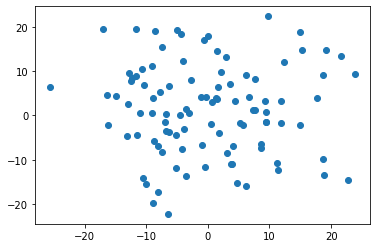

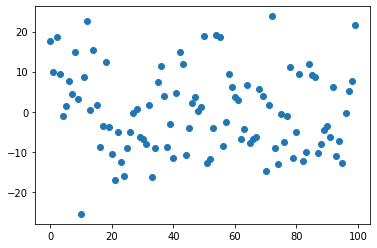

<Figure size 432x288 with 0 Axes>

In [4]:
twod_plot(A)
oned_plot(A[:,0])

In [ ]:
## Interpolation

QX: (50, 8)


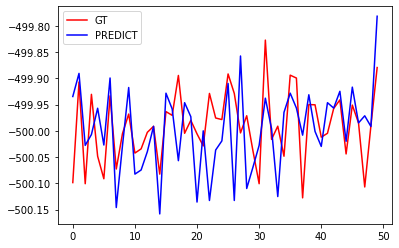

Difference between y and yhat:
Average Absolute: 0.0826175166577881


In [12]:
# Generate features and targets from different normal distributions
X = np.random.normal(loc=10, scale=0.1, size=(50,8))
y = np.random.normal(loc=-500, scale=0.1, size=(50, 1))

# Standardized data
normalizer = StandardScaler()
y_norm = normalizer.fit_transform(y)

# Define GPR using standardized target data
gpr = GaussianProcessRegressor(kernel=None,
        random_state=0, n_restarts_optimizer=0).fit(X, y_norm)

# Select indices for interpolation
idxes_A = np.random.randint(low=0, high=X.shape[0], size=50)
idxes_B = np.random.randint(low=0, high=X.shape[0], size=50)

# Form mean point queries between different points
qx = np.array([np.mean([X[idx_A],X[idx_B]], axis=0) for idx_A, idx_B in zip(idxes_A, idxes_B)])
qy = np.array([np.mean([y[idx_A],y[idx_B]]) for idx_A, idx_B in zip(idxes_A, idxes_B)])

# Reset variables
qx2 = X
qy2 = y

# Take inverse transform of GPR predictions
y_mean = normalizer.inverse_transform(gpr.predict(qx))
y_mean2 = normalizer.inverse_transform(gpr.predict(qx2))

# Plot results
plt.plot(np.arange(qy.shape[0]), qy, c="r", label="GT")
plt.plot(np.arange(y_mean.shape[0]), y_mean, c="b", label="PREDICT")
plt.legend()
plt.show()

# Capture performance differences
print("Difference between y and yhat:")
print("Average Absolute: {}".format(np.mean(np.abs(np.subtract(qy, y_mean)))))

## Example: Fitting a Multidimensional Sinusoid with Scikit-Learn GPR
We'll now apply this function to fitting a multidimensional sinusoid, which we have exact analytics results to compare against.

To see other analytic validation routines that can be carried out, please check out our `botorch` test suite in `./testing/test_functions_evaluation.py`.

In [140]:
# Generate features, and take norm for use with target
x = np.random.normal(loc=5, scale=5, size=(50, 2))
norm = np.linalg.norm(x, axis=1)

# Compute target
y = np.sin(norm)

# Fit GPR
gp = GaussianProcessRegressor().fit(x,y)
 
# Predict mean
yhat = gp.predict(x)

# Fit nearest neighbors
knn = NearestNeighbors(n_neighbors=50).fit(x)

(50,)


In [ ]:
# Select interpolation indices to find query points
idxes_A = np.random.randint(low=0, high=x.shape[0], size=50)
idxes_B = [knn.kneighbors(x[idx].reshape((1,-1)), 2, return_distance=False).flatten()[1] for idx in idxes_A]

# Compute query points
qx = np.array([np.mean([x[idx_A],x[idx_B]], axis=0) for idx_A, idx_B in zip(idxes_A, idxes_B)])

## Plot Interpolated and True Features
Note that because we interpolate along the mean points of other points, the query points (blue) will always lie halfway between true points (orange).

Text(0.5, 1.0, 'X')

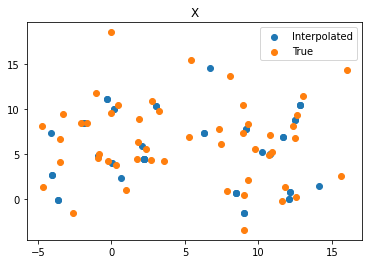

In [151]:
# Plot interpolated vs. ground truth
plt.scatter(qx[:,0], qx[:,1], label="Interpolated")
plt.scatter(x[:,0], x[:,1], label="True")
plt.legend()
plt.title("X")

## Plot Predicted vs. True Points
Lastly, we'll plot predicted targets (blue) vs. true targets (orange).  **Note**: If this doesn't work the first time, it might take some clever kernel manipulation and standardization to get this working!

AVERAGE ERROR: 0.1015098147210995


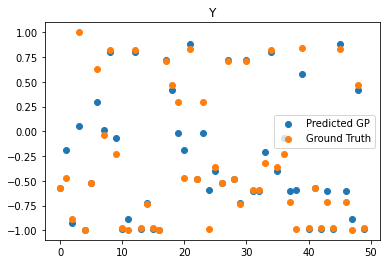

In [153]:
# Plot predicted vs. ground truth
qy_hat = gp.predict(qx)  # GP Interpolated
norm_qx = np.linalg.norm(qx, axis=1)
qy = np.sin(norm_qx)  # Ground truth
plt.scatter(np.arange(50), qy_hat, label="Predicted GP")
plt.scatter(np.arange(50), qy, label="Ground Truth")
plt.legend()
plt.title("Y")

error = {n}